  Install Libraries

In [1]:
!pip install sk-video

     |████████████████████████████████| 2.3MB 2.9MB/s 


Import Libraries

In [0]:
import skvideo.io  
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import operator
import random
from numba import prange
import plotly.express as px
from sklearn.cluster import KMeans
import warnings 
from scipy import stats

warnings.filterwarnings("ignore")

Import Video

In [3]:
video = skvideo.io.vread("/content/videoplayback.mp4")  
print(video.shape)

(1682, 360, 640, 3)


In [4]:
background = video[0].copy()
background.shape

(360, 640, 3)

Get Random Frames

In [0]:
n_frames = 20
frames_idx = []
for i in range(0, n_frames):
  frames_idx.append(random.randint(0, video.shape[0]))

Display randomly selected frames

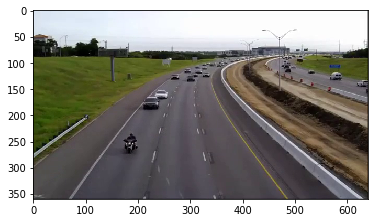

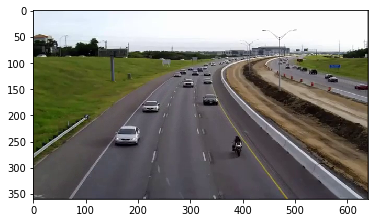

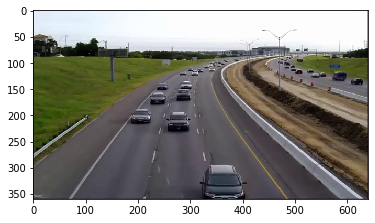

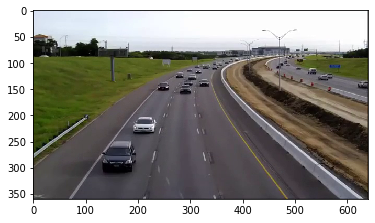

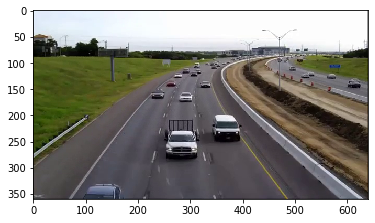

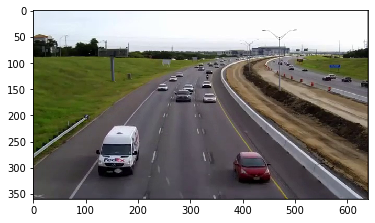

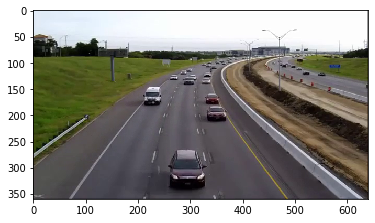

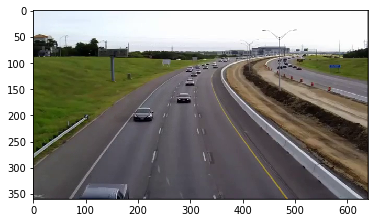

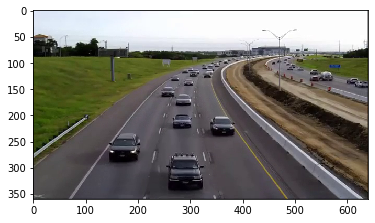

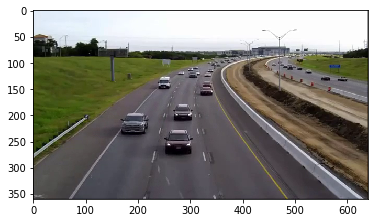

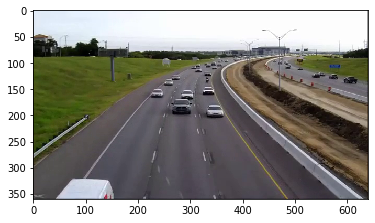

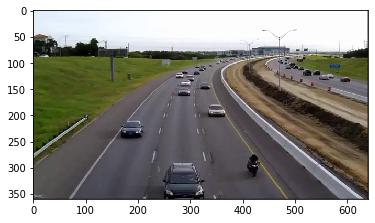

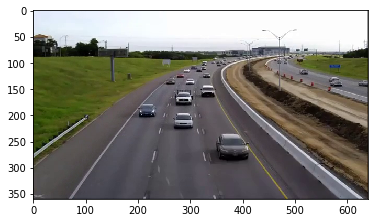

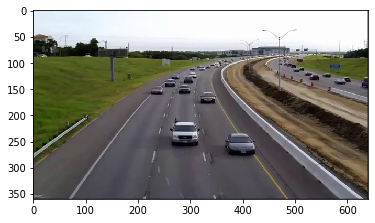

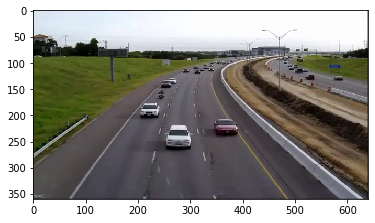

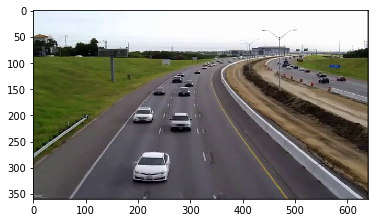

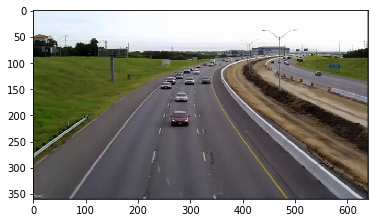

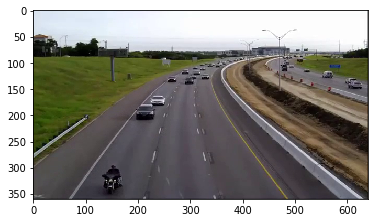

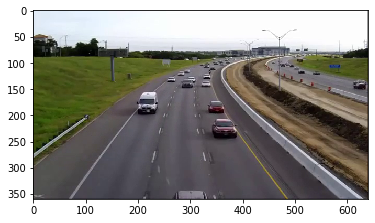

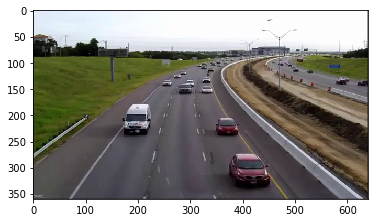

In [6]:
for frame in frames_idx:
  plt.imshow(video[frame])
  plt.show()

In [7]:
%%time
for x in prange(0, video.shape[2]):
  for y in prange(0, video.shape[1]):
    colors=[]
    for z in frames_idx:
      colors.append(video[z][y][x])
    ca = KMeans(n_clusters = 2)
    ca = ca.fit(colors)
    labels, counts = np.unique(ca.labels_, return_counts=True)
    clusters = dict(zip(labels, counts))
    most_common = max(clusters, key=clusters.get)
    colors_plot = colors
    if most_common == 1:
      colors = [colors[i] for i in np.where(np.array(ca.labels_))[0]]
    else:
      colors = [colors[i] for i in np.where(np.logical_not(np.array(ca.labels_)))[0]]
    colors_a = np.array(colors)
    background_pixel = []
    background_pixel.append(np.median(colors_a[:,0]))
    background_pixel.append(np.median(colors_a[:,1]))
    background_pixel.append(np.median(colors_a[:,2]))
    background[y][x] = background_pixel

CPU times: user 3h 12min 58s, sys: 20.6 s, total: 3h 13min 18s
Wall time: 3h 13min 9s


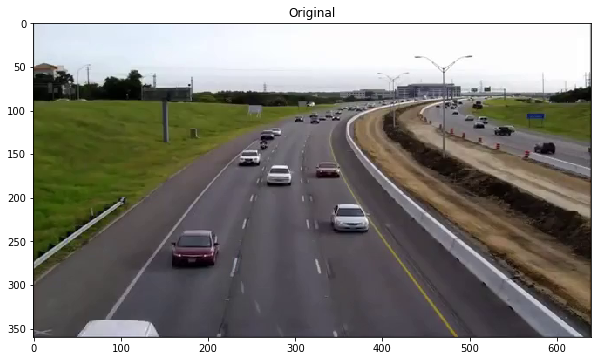

In [8]:
plt.figure(figsize=(10,10))
plt.imshow(video[0])
plt.title("Original")
plt.show()

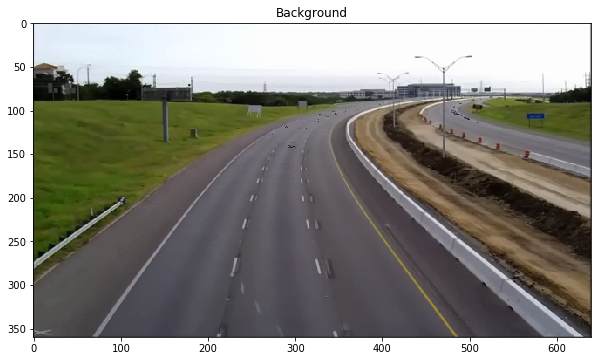

In [9]:
plt.figure(figsize=(10,10))
plt.imshow(background)
plt.title("Background")
plt.show()

In [0]:
video = video.astype("int16")
background = background.astype("int16")

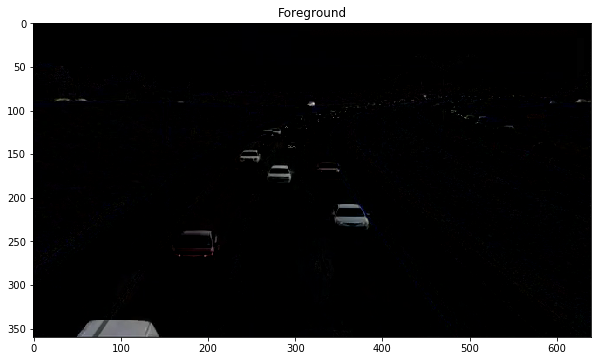

In [11]:
foreground = (video[0] - background)
np.clip(foreground, 0, 255, out=foreground)
plt.figure(figsize=(10,10))
plt.imshow(foreground)
plt.title("Foreground")
plt.show()

In [12]:
%%time
foreground = video.copy()
for i in range(0,foreground.shape[0]):
  foreground[i] = np.subtract(video[i], background)
  np.clip(foreground[i], 0, 255, out=foreground[i])
  foreground[i] = foreground[i].astype(np.uint8)

foreground = foreground.astype(np.uint8)
skvideo.io.vwrite("foreground.mp4", foreground)

CPU times: user 4.9 s, sys: 1.26 s, total: 6.16 s
Wall time: 14 s


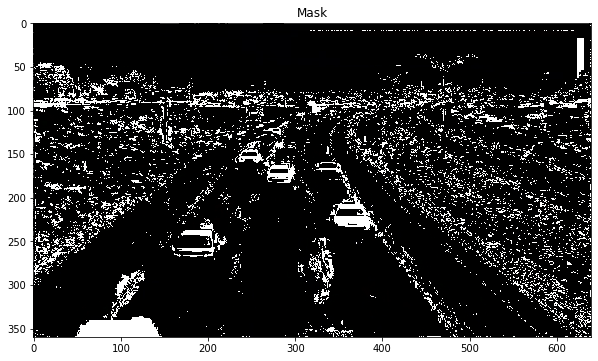

CPU times: user 2.47 s, sys: 6 ms, total: 2.48 s
Wall time: 2.48 s


In [13]:
%%time
mask = foreground[0].copy()
for x in prange(0, mask.shape[1]):
  for y in prange(0, mask.shape[0]):
    if np.mean(mask[y][x]) > 1:
      mask[y][x] = [255,255,255]
plt.figure(figsize=(10,10))
plt.imshow(mask)
plt.title("Mask")
plt.show()

In [16]:
%%time
mask = foreground.copy()
for i in range(0, mask.shape[2]):
  for x in prange(0, mask.shape[2]):
    for y in prange(0, mask.shape[1]):
      if np.mean(mask[i][y][x]) > 1:
        mask[i][y][x] = [255,255,255]
      else:
        mask[i][y][x] = [0,0,0]
mask = mask.astype(np.uint8)
skvideo.io.vwrite("mask.mp4", mask)

CPU times: user 31min 29s, sys: 771 ms, total: 31min 29s
Wall time: 31min 40s


In [15]:
pixel = pd.DataFrame(colors_plot, columns=["R","G","B"])
pixel["label"] = ca.labels_
fig = px.scatter_3d(pixel, x = "R", y = "G", z = "B", color="label")
fig.show()

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt


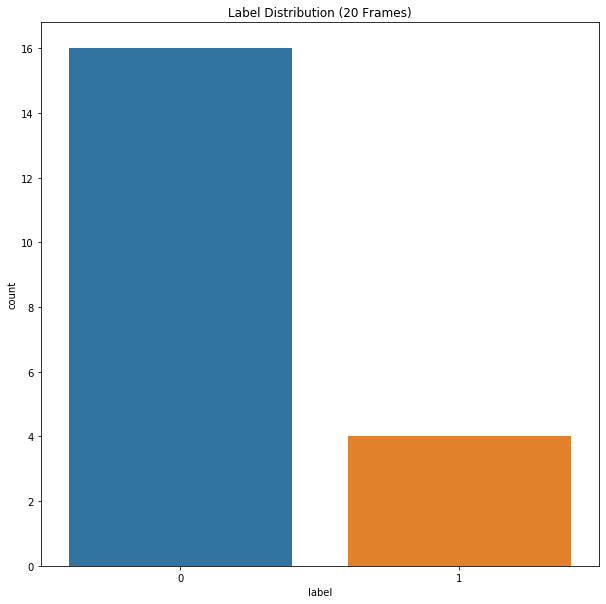

In [25]:
plt.figure(figsize=(10,10))
sns.countplot(data=pixel, x="label")
plt.title("Label Distribution (20 Frames)")
plt.show()